In [1]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
sys.path.append('./stockdqn')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:
# Getting the data
data = pd.read_csv('HDFC.NS.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(f"Data Min:{data.index.min()} \t Max: {data.index.max()}")

date_split = '2015-01-01'
train = data[:date_split]
test = data[date_split:]
print(f"Train len: {len(train)} \t Test len: {len(test)}")


Data Min:2002-07-01 00:00:00 	 Max: 2021-02-26 00:00:00
Train len: 2859 	 Test len: 1276


In [3]:
from env import Environment1

train_env = Environment1(train)
test_env = Environment1(test)

state_size = train_env.history_t+1

In [4]:
from dqn import NeuralNetwork

model_path = f"../model_1614471329.pt"

Q = NeuralNetwork(input_size=state_size, output_size=3)
if model_path is not None:
    Q.load_state_dict(torch.load(model_path))
    print(f"Loaded model saved at: {model_path}")
Q.to(device)


Loaded model saved at: ../model_1614471329.pt


NeuralNetwork(
  (fc1): Linear(in_features=91, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)

In [5]:
 # train
pobs = train_env.reset()
train_acts = []
train_rewards = []
actions = []

for _ in tqdm(range(len(train_env.data)-1)):

    pact = Q(pobs)
    pact = torch.argmax(pact.data)
    train_acts.append(pact)

    obs, reward, done = train_env.step(pact)
    train_rewards.append(reward)
    actions.append(pact.cpu())
    pobs = obs

train_profits = train_env.profits

# test
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in tqdm(range(len(test_env.data)-1)):

    pact = Q(pobs)
    pact = torch.argmax(pact.data)
    test_acts.append(pact)

    obs, reward, done = test_env.step(pact)
    test_rewards.append(reward)

    pobs = obs
    actions.append(pact.cpu())

test_profits = test_env.profits


100%|██████████| 1275/1275 [00:01<00:00, 705.77it/s]


In [6]:
actions = list(map(int,actions))
palette = {0: "yellow", 1: "r", 2: "g"}
colors = list()
for c in actions: colors.append(palette[c])

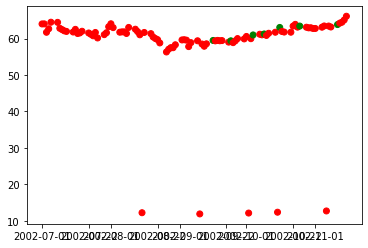

In [7]:
plt.scatter(train.index[:100],train["Close"][:100],c=colors[:len(train)][:100])


In [8]:
test_env.profits

1509.151497999998

In [9]:
train[date]

NameError: name 'date' is not defined

In [28]:
train.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-07-01,64.519997,65.000000,63.599998,63.996002,46.307896,813320
2002-07-02,64.000000,65.199997,63.750000,64.010002,46.318027,676020
2002-07-03,62.790001,62.799999,61.500000,61.706001,46.465614,139710
2002-07-04,62.000000,63.500000,62.000000,62.660000,47.183987,129020
2002-07-05,63.400002,65.000000,63.000000,64.466003,48.543934,627880


In [20]:
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.express as px

fig = px.scatter(train["Close"],color=actions[:len(train)])
fig.update_xaxes(rangeslider_visible=True)
fig.write_html('first_figure.html', auto_open=True)
